In [9]:
# Imports

import pandas as pd
import warnings
import plotly.express as px
import fbprophet
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from plotnine import *
from sklearn.metrics import mean_absolute_percentage_error

warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# Reading Dataset

filepath = 'data/AirPassengers.csv'
data = pd.read_csv(filepath)
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [3]:
# Missing Vals

data.isna().sum()

Month          0
#Passengers    0
dtype: int64

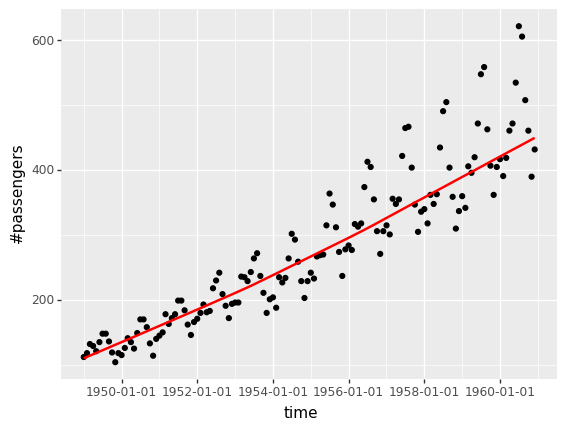

<ggplot: (8779493361207)>

In [5]:
# Plot Data

data['month_start'] = pd.to_datetime(data['Month'])

plot = (ggplot(data, aes(x='month_start', y='#Passengers')) +
        geom_point() +
        geom_smooth(color='red') +
        labs(x='time', y='#passengers') +
        scale_x_datetime()
)
plot

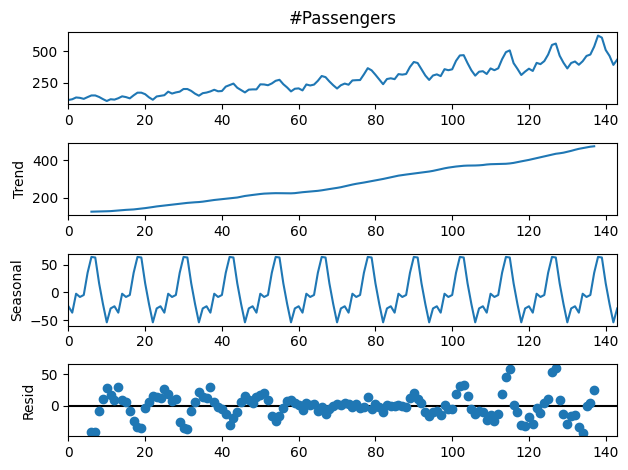

In [12]:
# Seasonal Decomposition

result = seasonal_decompose(data['#Passengers'], model='additive', period=12)
result.plot();

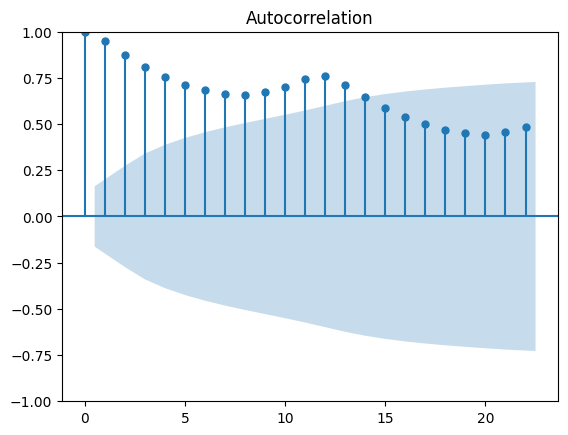

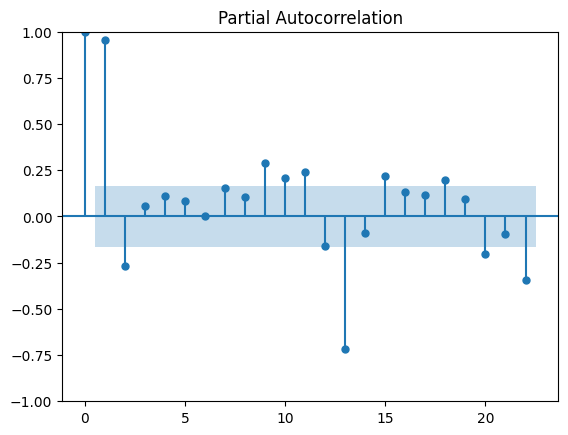

In [6]:
# PACF & ACF Plot

plot_acf(data['#Passengers']);
plot_pacf(data['#Passengers']);

In [7]:
# Adfuller Test

adfuller_result = adfuller(data['#Passengers'])
print(f'ADF Stat: {adfuller_result[0]}')
print(f'P Value: {adfuller_result[1]}')

ADF Stat: 0.8153688792060472
P Value: 0.991880243437641


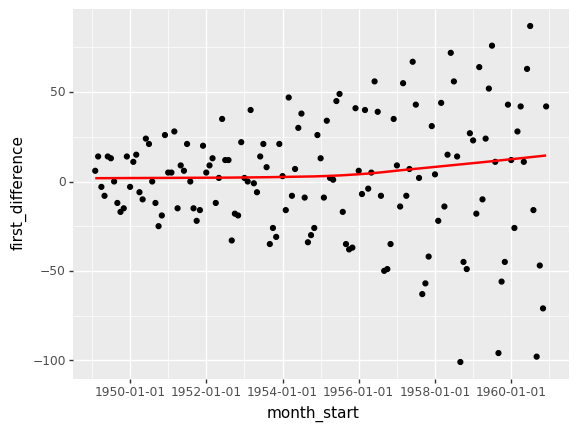

<ggplot: (8779494599798)>

In [14]:
# First Order Differencing

data['first_difference'] = data['#Passengers'].diff()

plot = (ggplot(data[1:].reset_index(drop=True), aes(x='month_start', y='first_difference')) + 
        geom_point() +
        geom_smooth(color='red') +
        scale_x_datetime()
        )   
plot

In [15]:
# Adfuller Test

adfuller_result = adfuller(data['first_difference'][1:])
print(f'ADF Stat: {adfuller_result[0]}')
print(f'P Value: {adfuller_result[1]}')

ADF Stat: -2.8292668241700056
P Value: 0.054213290283824704


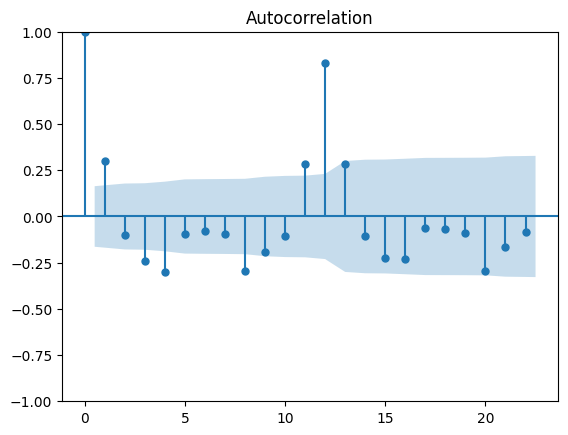

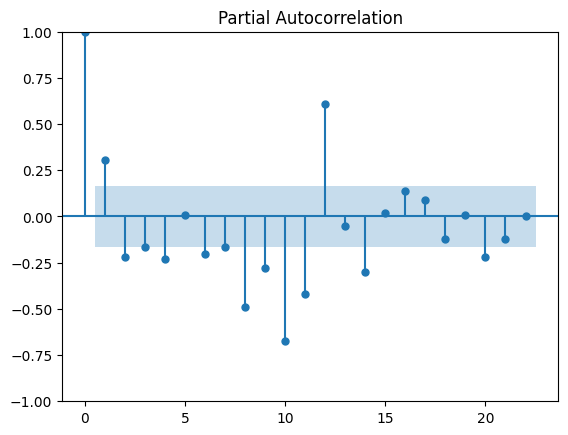

In [16]:
plot_acf(data['first_difference'][1:]);
plot_pacf(data['first_difference'][1:]);

In [25]:
# Setting up Data for Modelling

modelling_data = data.copy(deep=False)
modelling_data.rename(columns={'#Passengers': 'y',
                               'month_start' : 'ds'},
                      inplace=True)
modelling_data = modelling_data[['ds', 'y']]            

print(f'Total Data: {len(modelling_data)}')
TEST_SIZE = 24

train, test = modelling_data[:-TEST_SIZE], modelling_data[-TEST_SIZE:]
train

Total Data: 144


,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
...,...,...
115,1958-08-01,505
116,1958-09-01,404
117,1958-10-01,359
118,1958-11-01,310


In [42]:
# Train Model

model = fbprophet.Prophet()
model.fit(train)
test_forecast = model.predict(test)
test_forecast = test_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
test_forecast

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.56207
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       331.979   2.41758e-05       74.9252           1           1      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     129       332.073   0.000213971       77.6951   2.274e-06       0.001      248  LS failed, Hessian reset 
     170       332.099   2.10623e-05       89.3914   2.581e-07       0.001      337  LS failed, Hessian reset 
     199         332.1   3.54727e-08       69.8502      0.2656           1      373   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     201         332.1   6.10539e-08       61.5465       0.288           1      376   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


,ds,yhat,yhat_lower,yhat_upper
0,1959-01-01,390.272332,364.601380,412.557909
1,1959-02-01,387.759924,364.644458,411.108317
2,1959-03-01,418.818209,395.905249,443.020761
3,1959-04-01,412.874268,388.687707,436.491524
4,1959-05-01,417.556558,393.871370,442.196252
5,1959-06-01,452.425089,428.197739,475.012739
6,1959-07-01,487.074752,463.203847,511.750286
7,1959-08-01,484.769771,460.652634,507.574017
8,1959-09-01,447.253459,423.184344,472.134014
9,1959-10-01,415.003625,390.021763,438.499154


In [51]:
# Error

mape = mean_absolute_percentage_error(data['#Passengers'][-TEST_SIZE:], test_forecast['yhat'])
print(f'MAPE: {round(mape, 3)}%')


MAPE: 0.065%


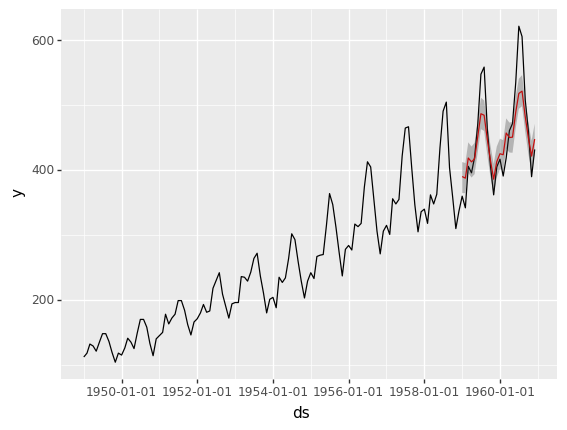

<ggplot: (8779497102297)>

In [50]:
# Plot

plot_data = pd.DataFrame()
plot_data = modelling_data.merge(test_forecast,
                                 on=['ds'],
                                 how='left')

plot = (ggplot(plot_data) + 
geom_line(aes(x='ds', y='y')) +
geom_line(aes(x='ds', y='yhat'), color='red') +
geom_ribbon(aes(x='ds', ymax='yhat_upper', ymin='yhat_lower'), alpha=0.3)
)
plot

In [66]:
# Future Prediction

periods = 24
model = fbprophet.Prophet().fit(modelling_data)
future_data = model.make_future_dataframe(periods=periods, freq='MS')
future_data = model.predict(future_data)
future_data

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.46502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       401.677     0.0020175       115.622           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     141       401.794   4.82967e-05       42.1404   7.387e-07       0.001      220  LS failed, Hessian reset 
     199       401.842   1.49854e-06       70.5045      0.4886      0.4886      292   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       401.936   0.000232074       99.9543      0.6462      0.6462      410   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     304       401.953   0.000121843       88.6191   1.268e-06       0.001      457  LS failed, Hessian reset 
     399        401.98   4.44813e-06       90.0668           1           1      573   
    Iter      log pro

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1949-01-01,107.460023,55.551687,115.533953,107.460023,107.460023,-21.432136,-21.432136,-21.432136,-21.432136,-21.432136,-21.432136,0.0,0.0,0.0,86.027887
1,1949-02-01,109.603691,51.353274,108.650441,109.603691,109.603691,-30.118003,-30.118003,-30.118003,-30.118003,-30.118003,-30.118003,0.0,0.0,0.0,79.485687
2,1949-03-01,111.539907,80.525155,138.203521,111.539907,111.539907,-0.538911,-0.538911,-0.538911,-0.538911,-0.538911,-0.538911,0.0,0.0,0.0,111.000996
3,1949-04-01,113.683575,79.835633,136.625394,113.683575,113.683575,-4.954686,-4.954686,-4.954686,-4.954686,-4.954686,-4.954686,0.0,0.0,0.0,108.728889
4,1949-05-01,115.758092,81.561851,141.386544,115.758092,115.758092,-3.615941,-3.615941,-3.615941,-3.615941,-3.615941,-3.615941,0.0,0.0,0.0,112.142151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,1962-08-01,546.024982,586.136364,643.464776,544.689021,547.494794,67.955266,67.955266,67.955266,67.955266,67.955266,67.955266,0.0,0.0,0.0,613.980248
164,1962-09-01,549.154147,536.894593,596.957038,547.731366,550.742710,16.930578,16.930578,16.930578,16.930578,16.930578,16.930578,0.0,0.0,0.0,566.084725
165,1962-10-01,552.182371,502.973429,559.529752,550.630862,553.883082,-21.800471,-21.800471,-21.800471,-21.800471,-21.800471,-21.800471,0.0,0.0,0.0,530.381900
166,1962-11-01,555.311536,466.569749,529.407962,553.626492,557.198823,-57.793455,-57.793455,-57.793455,-57.793455,-57.793455,-57.793455,0.0,0.0,0.0,497.518081


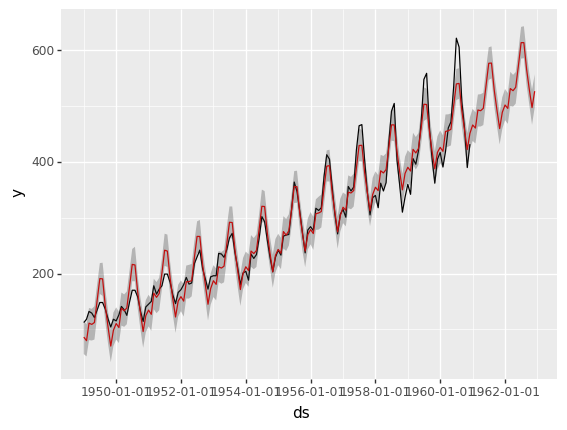

<ggplot: (8779497186744)>

In [67]:
# Future Plot

plot_data = modelling_data.merge(future_data, on=['ds'], how='right')

plot = (ggplot(plot_data) + 
geom_line(aes(x='ds', y='y')) +
geom_line(aes(x='ds', y='yhat'), color='red') +
geom_ribbon(aes(x='ds', ymax='yhat_upper', ymin='yhat_lower'), alpha=0.3)
)
plot

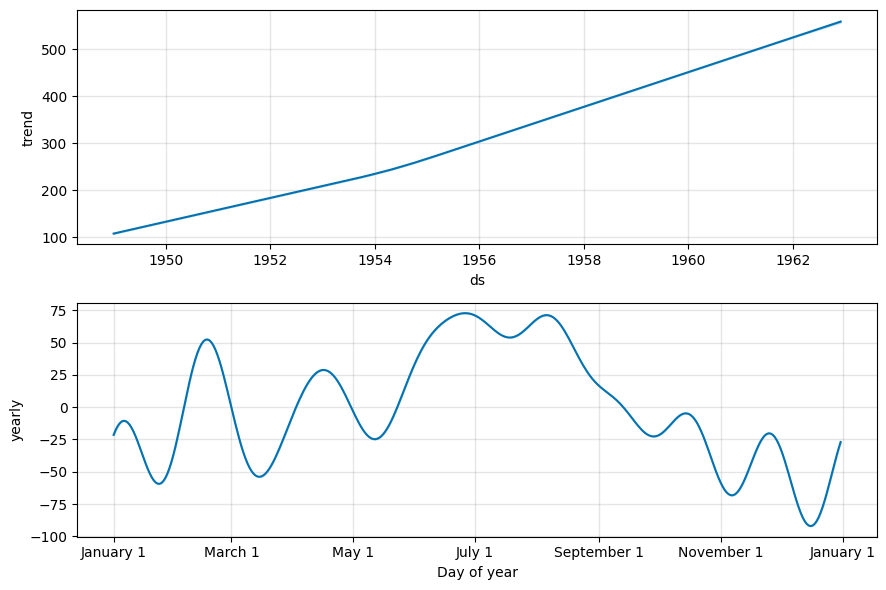

In [69]:
model.plot_components(future_data);